In [172]:
import numpy as np
import pandas as pd
import lxml.etree as etree
import sqlite3 as sql
from process import *
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [405]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, precision_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [3]:
data = pd.read_csv('../data/prem_data_elo.csv', index_col = 'Unnamed: 0')
data.head()

,match_api_id,league_id,date,home_team_api_id,home_team_name,away_team_api_id,away_team_name,home_team_goal,away_team_goal,home_team_foul_reason_from_behind,...,away_team_card_reason_pushing,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,result,home_elo,away_elo
0,489044,1729,2008-08-16 00:00:00,8472,Sunderland,8650,Liverpool,0,2,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
1,489045,1729,2008-08-16 00:00:00,8654,West Ham United,8528,Wigan Athletic,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
2,489047,1729,2008-08-16 00:00:00,8668,Everton,8655,Blackburn Rovers,2,12,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
3,489048,1729,2008-08-16 00:00:00,8549,Middlesbrough,8586,Tottenham Hotspur,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
4,489049,1729,2008-08-16 00:00:00,8559,Bolton Wanderers,10194,Stoke City,3,4,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0


In [136]:
X = data[data.columns[9:]].drop(
    ['result', 'home_elo', 'away_elo'],
axis = 1)
y = data['result']

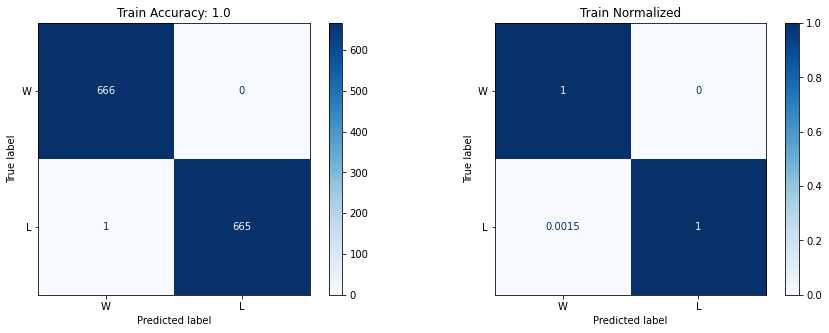

   Class  Accuracy  Precision    Recall        F1  Support
0      W  1.000000   0.998501  1.000000  0.999250      666
1      L  0.998498   1.000000  0.998498  0.999249      666
2  Total  0.999249   0.999250  0.999249  0.999249     1332


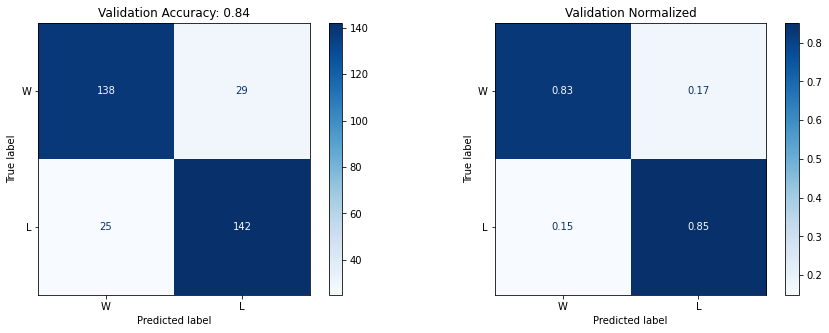

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.826347   0.846626  0.826347  0.836364      167
1      L  0.850299   0.830409  0.850299  0.840237      167
2  Total  0.838323   0.838518  0.838323  0.838300      334


In [7]:
X_ds, y_ds, weights = transform_target(X, y, class_labels = ['W', 'L'], weight = True, down_sample = True)
X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size = 0.2, stratify = y_ds)

clf = RFpipe(weights = weights).fit(X_train, y_train)
print(metric_suite(clf, X_train, y_train, labels = ['W', 'L'], type_ = 'Train', cm = True, save = 'train_cm.png'))
print(metric_suite(clf, X_test, y_test, labels = ['W', 'L'], type_ = 'Validation', cm = True, save = 'valid_cm.png'))

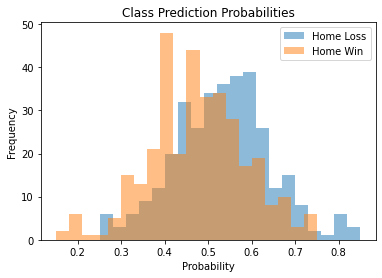

In [66]:
plt.hist(clf['rf'].predict_proba(X_test.values)[:, 0], alpha = 0.5, bins = 20)
plt.hist(clf['rf'].predict_proba(X_test.values)[:, 1], alpha = 0.5, bins = 20)
plt.legend(labels = ['Home Loss', 'Home Win'])
plt.title('Class Prediction Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.savefig('rf_class_probs.png', dpi = 200)
plt.show()

In [141]:
r = permutation_importance(clf, X_test, y_test, n_repeats = 30)

qual_idx = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] > 0:
        qual_idx += [i]
        print("{feat}\t\t{mean} +/- {std}".format(
            feat = X.columns[i],
            mean = np.round(r.importances_mean[i], 3),
            std = np.round(r.importances_std[i], 3)
        ))

home_team_card_color_y		0.092 +/- 0.018
home_team_foul_reason_penalty		0.024 +/- 0.007
away_team_card_reason_stall_time		0.017 +/- 0.005
home_team_foul_reason_pull		0.016 +/- 0.006
away_team_card_reason_pushing		0.009 +/- 0.002


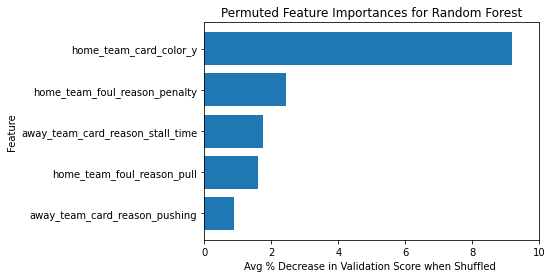

In [151]:
plt.barh(X.columns[qual_idx][::-1], r.importances_mean[qual_idx][::-1]*100)
plt.title('Permuted Feature Importances for Random Forest')
plt.xlabel('Avg % Decrease in Validation Score when Shuffled ')
plt.ylabel('Feature')
plt.xticks(range(0, 11, 2))
plt.savefig('feat_imp_rf.png', dpi = 200, bbox_inches='tight')
plt.show()

In [94]:
print("Min depth", np.min([x.tree_.max_depth for x in clf['rf'].estimators_]))
np.argmin([x.tree_.max_depth for x in clf['rf'].estimators_])

Min depth 27


52

In [115]:
path = clf['rf'].estimators_[52].cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [138]:
X_ds, y_ds, weights = transform_target(X, y, class_labels = ['W', 'L'], weight = True, down_sample = True)
X_ds = StandardScaler().fit_transform(X_ds)
y_ds_mod = np.array([0 if i == 'L' else 1 for i in y])

In [139]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(clf['rf'].estimators_[52], X_ds, y_ds_mod,
                target_name="result",
                feature_names= X.columns,
                class_names= list(clf.classes_))

viz.save("decision_tree.svg")

In [131]:
from sklearn import tree

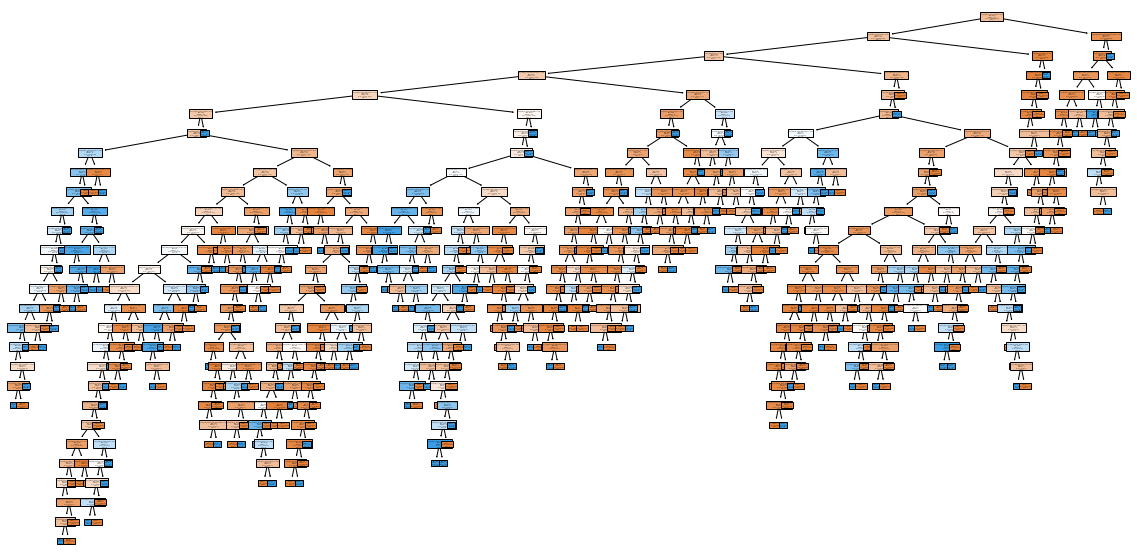

In [135]:
fig, axs = plt.subplots(figsize = (20,10))
tree.plot_tree(clf['rf'].estimators_[52], feature_names = X.columns, class_names = list(clf.classes_), filled = True)
plt.savefig('sklearn_tree.png', dpi = 1000)
plt.show()

In [180]:
r = re.compile(".*card_color")
cc_columns = list(filter(r.match, list(X.columns)))

In [181]:
import itertools
combos = [list(subset) for subset in itertools.combinations(cc_columns, 2)]
len(combos)

15

In [187]:
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

In [218]:
a, b = np.where(upper_tri > 0.6)
for w, z in zip(cor_matrix.columns[a], cor_matrix.columns[b]):
    print(w, ' & ', z, np.round(cor_matrix[w][z], 3))

home_team_foul_reason_pushing  &  away_team_foul_reason_pushing 0.611
home_team_foul_reason_serious_foul  &  home_team_card_reason_serious_fouls 0.649
away_team_foul_reason_serious_foul  &  away_team_card_reason_serious_fouls 0.654
home_team_foul_reason_trip  &  away_team_foul_reason_trip 0.772
away_team_foul_reason_diving  &  away_team_card_reason_diving 0.616


In [274]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
to_drop

['away_team_foul_reason_from_behind',
 'away_team_foul_reason_pushing',
 'away_team_foul_reason_trip',
 'home_team_card_reason_serious_fouls',
 'away_team_card_reason_serious_fouls',
 'home_team_card_reason_diving',
 'away_team_card_reason_diving']

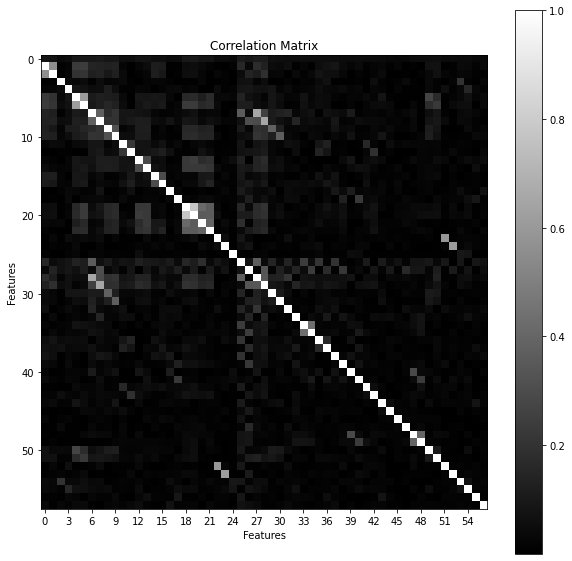

In [303]:
down_cor = cor_matrix.drop('home_team_foul_reason_goalkeeper_hands',axis=1).drop('home_team_foul_reason_goalkeeper_hands',axis=0)
fig, axs= plt.subplots(figsize = (10,10))
plt.imshow(np.row_stack([down_cor.apply(np.mean, axis = 0), down_cor.values]), cmap = 'gray')
plt.colorbar()
plt.xticks(range(0,57,3))
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Correlation Matrix')
plt.savefig('cor_mat.png', dpi = 200, bbox_inches = 'tight')
plt.show()

In [714]:
X_ds

array([[-0.50114457, -0.54856895, -0.57866235, ..., -0.15070939,
        -0.11568057, -0.06495698],
       [ 7.65224271,  2.1367862 , -0.57866235, ..., -0.15070939,
        -0.11568057, -0.06495698],
       [-0.50114457,  1.68922701, -0.57866235, ..., -0.15070939,
        -0.11568057, -0.06495698],
       ...,
       [-0.50114457, -0.54856895, -0.57866235, ..., -0.15070939,
        -0.11568057, -0.06495698],
       [-0.50114457, -0.54856895,  1.07778349, ..., -0.15070939,
        -0.11568057, -0.06495698],
       [-0.50114457, -0.54856895,  1.07778349, ..., -0.15070939,
        -0.11568057, -0.06495698]])

  0%|          | 0/15 [00:00<?, ?it/s]

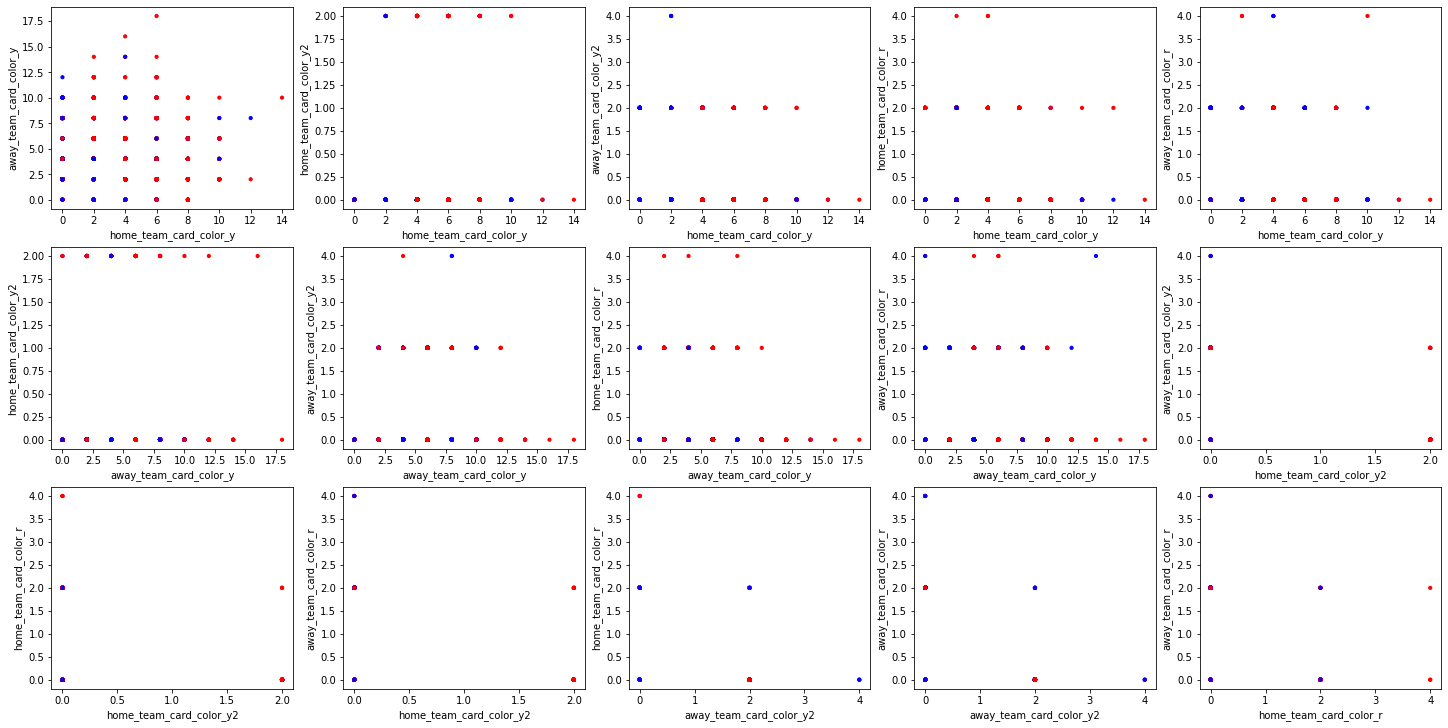

In [716]:
fig, axs = plt.subplots(3, 5, figsize = (20,10), constrained_layout = True)
for i, ax in enumerate(tqdm(axs.flat)):
    a, b = combos[i]
    ax.scatter(X[a], X[b], c = ['r' if x == 'L' else 'b' for x in y], s = 10)
    ax.set_xlabel(a)
    ax.set_ylabel(b)
plt.show()

In [312]:
clf_logit = train_test(Logitpipe, X.drop(to_drop, axis = 1), y, weight = True, down_sample = True, class_labels = ['W', 'L'], return_clf = True)

>>>Preprocess done {'W': 1.0, 'L': 2.061224489795918}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.400901   0.782991  0.400901  0.530288      666
1      L  0.888889   0.597376  0.888889  0.714544      666
2  Total  0.644895   0.690184  0.644895  0.622416     1332
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.449102   0.742574  0.449102  0.559701      167
1      L  0.844311   0.605150  0.844311  0.705000      167
2  Total  0.646707   0.673862  0.646707  0.632351      334


In [316]:
clf_drop = train_test(RFpipe, X.drop(to_drop, axis = 1), y, weight = True, down_sample = True, class_labels = ['W', 'L'], return_clf = True)

>>>Preprocess done {'W': 1.0, 'L': 2.061224489795918}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.990991   1.000000  0.990991  0.995475      666
1      L  1.000000   0.991071  1.000000  0.995516      666
2  Total  0.995495   0.995536  0.995495  0.995495     1332
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.790419   0.835443  0.790419  0.812308      167
1      L  0.844311   0.801136  0.844311  0.822157      167
2  Total  0.817365   0.818290  0.817365  0.817233      334


In [296]:
r = permutation_importance(clf_drop, X_test.drop(to_drop, axis=1), y_test, n_repeats = 30)

qual_idx = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] > 0:
        qual_idx += [i]
        print("{feat}\t\t{mean} +/- {std}".format(
            feat = X.drop(to_drop, axis = 1).columns[i],
            mean = np.round(r.importances_mean[i], 3),
            std = np.round(r.importances_std[i], 3)
        ))

home_team_card_color_y		0.072 +/- 0.017
home_team_foul_reason_penalty		0.034 +/- 0.007
home_team_foul_reason_serious_foul		0.022 +/- 0.007
away_team_foul_reason_pull		0.02 +/- 0.009
away_team_card_reason_stall_time		0.019 +/- 0.006
away_team_card_color_r		0.018 +/- 0.007
home_team_foul_reason_shirt_pull		0.018 +/- 0.006
away_team_foul_reason_shirt_pull		0.017 +/- 0.004
away_team_card_color_y2		0.007 +/- 0.003
home_team_card_reason_stall_time		0.006 +/- 0.002


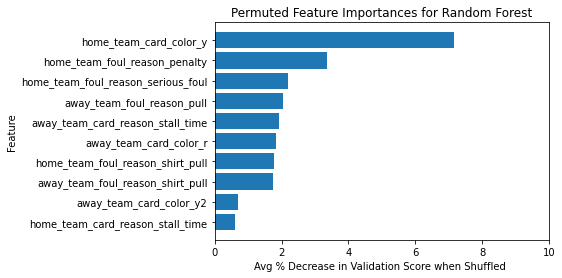

In [317]:
plt.barh(X.drop(to_drop, axis = 1).columns[qual_idx][::-1], r.importances_mean[qual_idx][::-1]*100)
plt.title('Permuted Feature Importances for Random Forest')
plt.xlabel('Avg % Decrease in Validation Score when Shuffled ')
plt.ylabel('Feature')
plt.xticks(range(0, 11, 2))
#plt.savefig('feat_imp_rf.png', dpi = 200, bbox_inches='tight')
plt.show()

In [831]:
X_drop = X.drop(to_drop + ['home_team_foul_reason_goalkeeper_hands', 'away_team_foul_reason_goalkeeper_hands'], axis = 1)

In [339]:
from sklearn.metrics.pairwise import manhattan_distances
from scipy.stats import iqr

In [338]:
mean = X_drop.mean(axis = 0).values
std = X_drop.std(axis = 0)
manhattan_distances(X_drop, mean.reshape(1, -1)).reshape(-1)

array([18.22102332, 21.86355726, 23.85798817, ..., 20.69787678,
       32.2540898 , 22.84893839])

In [847]:
labels.shape

(49,)

  0%|          | 0/25 [00:00<?, ?it/s]

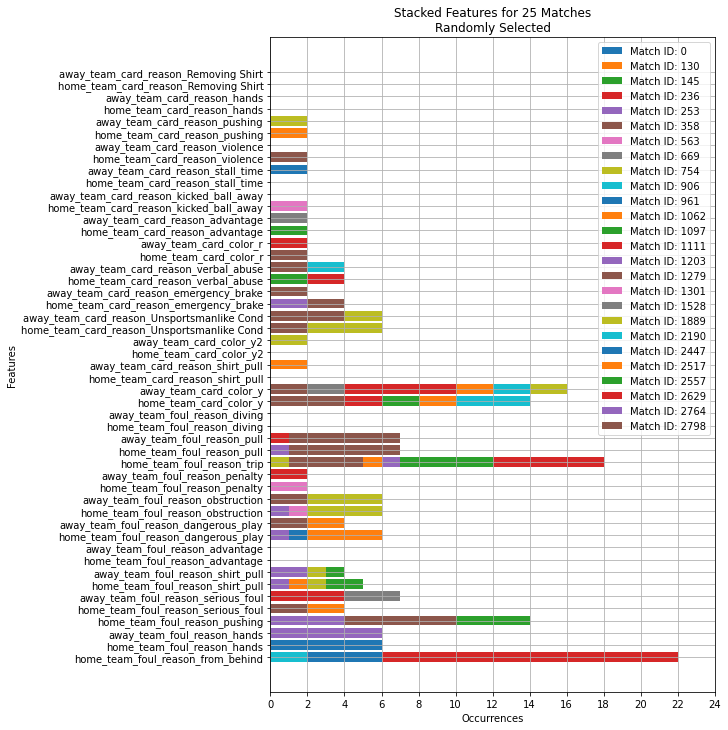

In [845]:
labels = X_drop.columns
vals = X_drop[labels].values
vals = vals[vals.sum(axis = 1) != 0]
fig, axs = plt.subplots(figsize = (10,10), constrained_layout = True)
np.random.seed(1)
axs.barh(labels, vals[0], label = "Match ID: 0")
idx = sorted(np.random.choice(np.arange(1,vals.shape[0]), size = 25))
#idx = range(vals.shape[0])
for i,id_ in enumerate(tqdm(idx)):
    axs.barh(labels, vals[id_], left = list(vals[idx[i-1]]), label = "Match ID: {id}".format(id = id_))
plt.legend()
plt.xticks(range(0, 26,2))
plt.grid()
plt.title('Stacked Features for 25 Matches\nRandomly Selected')
plt.xlabel('Occurrences')
plt.ylabel('Features')
plt.savefig('stacked_bar_feat.png', dpi = 400, bbox_inches = 'tight')
plt.show()

  0%|          | 0/49 [00:00<?, ?it/s]

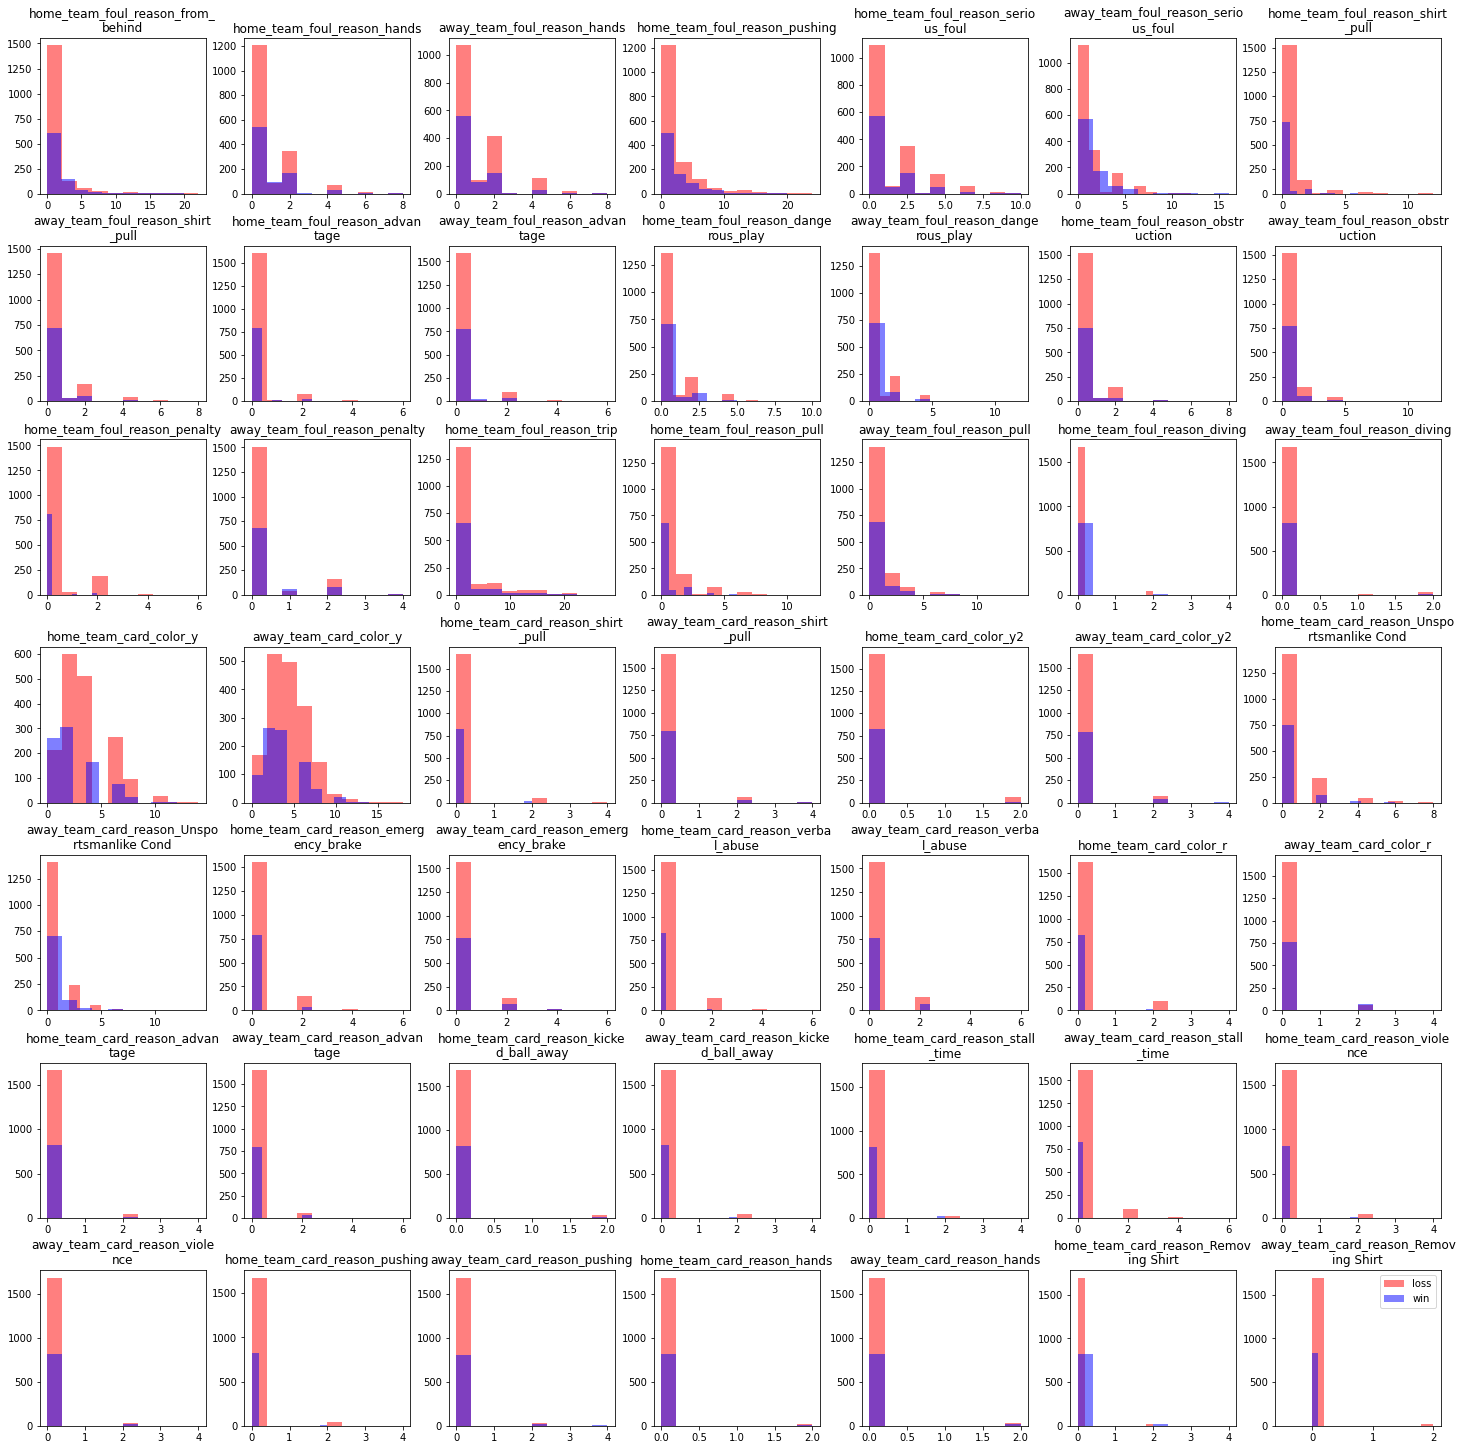

In [846]:
fig, axs = plt.subplots(7, 7, figsize= (20,20), constrained_layout = True)
for i, ax in enumerate(tqdm(axs.flat)):
    ax.hist(X_drop[X_drop.columns[i]][y == 'L'],alpha = 0.5, color = 'r')
    ax.hist(X_drop[X_drop.columns[i]][y == 'W'],alpha = 0.5, color = 'b')
    ax.set_title(X_drop.columns[i] if len(X_drop.columns[i]) < 30 else X_drop.columns[i][:27] + '\n' + X_drop.columns[i][27:])
plt.legend(labels = ['loss', 'win'])
plt.savefig('singlevar_eda.png', dpi = 400, bbox_inches = 'tight')
plt.show()

In [387]:
home_fouls = X_drop[y != 'D'].filter(regex = 'home_team_foul').sum(axis = 1)
away_fouls = X_drop[y != 'D'].filter(regex = 'away_team_foul').sum(axis = 1)
home_cards = X_drop[y != 'D'].filter(regex = 'home_team_card_reason').sum(axis = 1)
away_cards = X_drop[y != 'D'].filter(regex = 'away_team_card_reason').sum(axis = 1)

In [378]:
print("HFouls >= Afouls & W: ", np.round(np.mean((home_fouls >= away_fouls) & (data[y != 'D']['result'] == 'W'))*100, 1), '%')
print("HFouls >= Afouls & L: ", np.round(np.mean((home_fouls >= away_fouls) & (data[y != 'D']['result'] == 'L'))*100, 1), '%')
print("HFouls < Afouls & W: ", np.round(np.mean((home_fouls < away_fouls) & (data[y != 'D']['result'] == 'W'))*100, 1), '%')
print("HFouls < Afouls & L: ", np.round(np.mean((home_fouls < away_fouls) & (data[y != 'D']['result'] == 'L'))*100, 1), '%')

HFouls >= Afouls & W:  24.2 %
HFouls >= Afouls & L:  55.5 %
HFouls < Afouls & W:  8.4 %
HFouls < Afouls & L:  11.9 %


In [389]:
print("HCards >= ACards & W: ", np.round(np.mean((home_cards >= away_cards) & (data[y != 'D']['result'] == 'W'))*100, 1), '%')
print("HCards >= ACards & L: ", np.round(np.mean((home_cards >= away_cards) & (data[y != 'D']['result'] == 'L'))*100, 1), '%')
print("HCards < ACards & W: ", np.round(np.mean((home_cards < away_cards) & (data[y != 'D']['result'] == 'W'))*100, 1), '%')
print("HCards < ACards & L: ", np.round(np.mean((home_cards < away_cards) & (data[y != 'D']['result'] == 'L'))*100, 1), '%')

HCards >= ACards & W:  22.6 %
HCards >= ACards & L:  46.8 %
HCards < ACards & W:  10.0 %
HCards < ACards & L:  20.5 %


In [394]:
print('Home Wins', np.round(np.mean(data[y != 'D']['result'] == 'W')*100, 1), '%')
print('Home Losses', np.round(np.mean(data[y != 'D']['result'] == 'L')*100, 1), '%')

Home Wins 32.7 %
Home Losses 67.3 %


In [664]:
#leaves
def leaf_pct(estim, threshold):
    return np.sum(sorted(np.round(np.unique(clf['rf'].estimators_[estim].apply(X_test), return_counts = True)[1]/X_test.shape[0]*100,2))[::-1][:threshold])


In [682]:
pct = [leaf_pct(x, 2) for x in range(len(clf['rf'].estimators_))]

In [692]:
class LeanClassifier:
    
    def __init__(self, base_clf, pct, scale = True, threshold = 50):
        self.base_clf = base_clf
        self.pct = pct
        self.scale = scale
        self.threshold = threshold
        
        self.good_estim = np.where(np.array(pct) > threshold)[0]
        if self.good_estim.shape[0] == 0:
            self.good_estim = [np.argmax(pct)]
        
        self.tree = np.array(self.base_clf['rf'].estimators_)[self.good_estim]
        
    def predict(self, X):
        X_ = X
        if self.scale:
            X_ = self.base_clf['scaler'].transform(X)
        
        class_probs = np.row_stack([
            np.apply_along_axis(lambda x: x[0] - x[1], -1, x.predict_proba(X_)) for x in self.tree
        ]).mean(axis=0)
        
        pred = np.zeros(class_probs.shape[0], dtype = object)
        pred[np.where(class_probs < 0)] = 'W'
        pred[np.where(class_probs >= 0)] = 'L'
    
        return pred
    
    def score(self, X, y):
        return np.mean(self.predict(X) == y)

In [683]:
tune = [LeanClassifier(X_test, y_test, threshold = x) for x in tqdm(range(100))]

  0%|          | 0/100 [00:00<?, ?it/s]

In [693]:
lean_clf = LeanClassifier(clf, pct, threshold = np.argmax(tune))

In [694]:
clf.score(X_train, y_train), lean_clf.score(X_train, y_train)

(0.9992492492492493, 0.9984984984984985)

In [695]:
clf.score(X_test, y_test), lean_clf.score(X_train, y_train)

(0.8383233532934131, 0.9984984984984985)

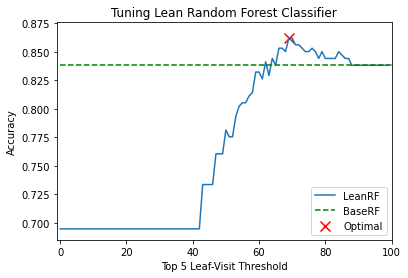

In [686]:
plt.plot(tune[::-1])
plt.plot([0, 100],[0.838323, 0.838323], 'g--')
plt.scatter(np.argmax(tune[::-1]), np.max(tune), marker = 'x', color = 'r', s = 100)
plt.title('Tuning Lean Random Forest Classifier')
plt.xlabel('Top 5 Leaf-Visit Threshold')
plt.ylabel('Accuracy')
plt.legend(labels = ['LeanRF', 'BaseRF', 'Optimal'])
plt.ylim([0.685, 0.876])
plt.xlim([-1,100])
plt.show()

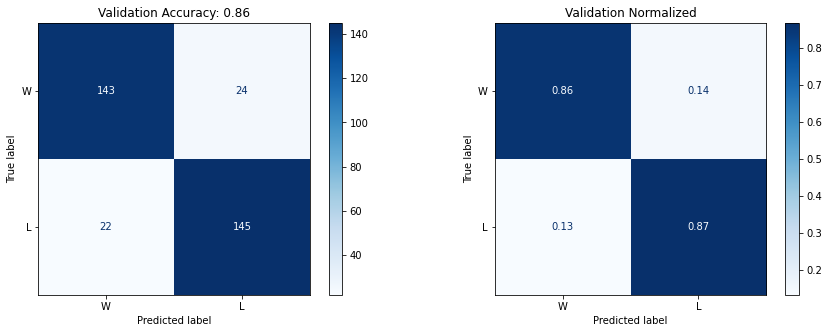

In [687]:
CM(LeanClassifier(X_test, threshold = np.argmax(tune)), y_test, type_ = 'Validation', labels = ['W', 'L'])#, save = 'lean_valid_cm.png')

In [696]:
X

,home_team_foul_reason_from_behind,away_team_foul_reason_from_behind,home_team_foul_reason_hands,away_team_foul_reason_hands,home_team_foul_reason_pushing,away_team_foul_reason_pushing,home_team_foul_reason_serious_foul,away_team_foul_reason_serious_foul,home_team_foul_reason_shirt_pull,away_team_foul_reason_shirt_pull,...,home_team_card_reason_violence,away_team_card_reason_violence,home_team_card_reason_pushing,away_team_card_reason_pushing,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt
0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,4.0,0.0,2.0,2.0,0.0,2.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,2.0,0.0,4.0,0.0,2.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,4.0,0.0,2.0,2.0,4.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,6.0,2.0,2.0,8.0,2.0,2.0,4.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,2.0,2.0,0.0,0.0,2.0,4.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2869,0.0,2.0,0.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2870,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2871,0.0,0.0,0.0,0.0,2.0,2.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
